# Import packages and classes

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time

import statsmodels.api as sm

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Suppress scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Define a function

In [3]:
# Convert timestamp to date format
# Useful for making the timestamp humanely friendly

def timestampToDate(timestamp):
    
    return timestampToDateTime(timestamp).date()

In [4]:
# Convert timestamp to date and time format
# Useful for making the timestamp humanely friendly

def timestampToDateTime(timestamp):
    
    return datetime.fromtimestamp(timestamp)

# Importing the data

In [5]:
dfOriginal = pd.read_csv('Datasets/rvnHalvingPrediction.csv')
df = dfOriginal.copy()
df

,Unnamed: 0,height,time
0,0,1778781,1622516234
1,1,1778780,1622516196
2,2,1778779,1622516185
3,3,1778778,1622516158
4,4,1778777,1622515956
...,...,...,...
1774755,1774755,5,1515015840
1774756,1774756,4,1515015833
1774757,1774757,3,1515015816
1774758,1774758,2,1515015759


In [6]:
df.dtypes

Unnamed: 0    int64
height        int64
time          int64
dtype: object

# Data Transformation

In [7]:
# Missing values by columns/variables
df.isna().sum()

Unnamed: 0    0
height        0
time          0
dtype: int64

In [8]:
# Removing garbage
df = df.drop('Unnamed: 0', 1)

df.head(10)

,height,time
0,1778781,1622516234
1,1778780,1622516196
2,1778779,1622516185
3,1778778,1622516158
4,1778777,1622515956
5,1778776,1622515953
6,1778775,1622515941
7,1778774,1622515909
8,1778773,1622515865
9,1778772,1622515833


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774760 entries, 0 to 1774759
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   height  int64
 1   time    int64
dtypes: int64(2)
memory usage: 27.1 MB


# Data exploration

Check the average time elapsed between blocks being generated monthly

In [10]:
dfExploration = df.copy()
dfExploration

,height,time
0,1778781,1622516234
1,1778780,1622516196
2,1778779,1622516185
3,1778778,1622516158
4,1778777,1622515956
...,...,...
1774755,5,1515015840
1774756,4,1515015833
1774757,3,1515015816
1774758,2,1515015759


In [11]:
# Handling the dates
dfExploration['dateTime']  = dfExploration['time']
dfExploration['dateTime']  = dfExploration['dateTime'].apply(timestampToDateTime)
dfExploration['monthYear'] = dfExploration['dateTime'].dt.to_period('M')                     

dfExploration.head(10)

,height,time,dateTime,monthYear
0,1778781,1622516234,2021-05-31 23:57:14,2021-05
1,1778780,1622516196,2021-05-31 23:56:36,2021-05
2,1778779,1622516185,2021-05-31 23:56:25,2021-05
3,1778778,1622516158,2021-05-31 23:55:58,2021-05
4,1778777,1622515956,2021-05-31 23:52:36,2021-05
5,1778776,1622515953,2021-05-31 23:52:33,2021-05
6,1778775,1622515941,2021-05-31 23:52:21,2021-05
7,1778774,1622515909,2021-05-31 23:51:49,2021-05
8,1778773,1622515865,2021-05-31 23:51:05,2021-05
9,1778772,1622515833,2021-05-31 23:50:33,2021-05


In [12]:
# Time between blocks

dfExploration['secondsBetweenBlocks'] = dfExploration['dateTime'].diff().astype('timedelta64[s]')*-1
dfExploration['secondsBetweenBlocks'] = dfExploration['secondsBetweenBlocks'].fillna(0)
dfExploration.head(10)

,height,time,dateTime,monthYear,secondsBetweenBlocks
0,1778781,1622516234,2021-05-31 23:57:14,2021-05,0.00000
1,1778780,1622516196,2021-05-31 23:56:36,2021-05,38.00000
2,1778779,1622516185,2021-05-31 23:56:25,2021-05,11.00000
3,1778778,1622516158,2021-05-31 23:55:58,2021-05,27.00000
4,1778777,1622515956,2021-05-31 23:52:36,2021-05,202.00000
5,1778776,1622515953,2021-05-31 23:52:33,2021-05,3.00000
6,1778775,1622515941,2021-05-31 23:52:21,2021-05,12.00000
7,1778774,1622515909,2021-05-31 23:51:49,2021-05,32.00000
8,1778773,1622515865,2021-05-31 23:51:05,2021-05,44.00000
9,1778772,1622515833,2021-05-31 23:50:33,2021-05,32.00000


In [13]:
# After verifying that the time between blocks is correct, time and dateTime can be deleted
dfExploration = dfExploration.drop('time', 1)
dfExploration = dfExploration.drop('dateTime', 1)
dfExploration = dfExploration.drop('height', 1)
dfExploration.head(10)

,monthYear,secondsBetweenBlocks
0,2021-05,0.00000
1,2021-05,38.00000
2,2021-05,11.00000
3,2021-05,27.00000
4,2021-05,202.00000
5,2021-05,3.00000
6,2021-05,12.00000
7,2021-05,32.00000
8,2021-05,44.00000
9,2021-05,32.00000


In [14]:
# seconds between blocks
dfExploration = dfExploration.groupby('monthYear').mean('secondsBetweenBlocks')

dfExploration

,secondsBetweenBlocks
monthYear,
2018-01,45.78702
2018-02,54.31378
2018-03,56.14346
2018-04,61.29363
2018-05,59.86616
2018-06,60.45927
2018-07,63.21432
2018-08,134.28796
2018-09,60.41391


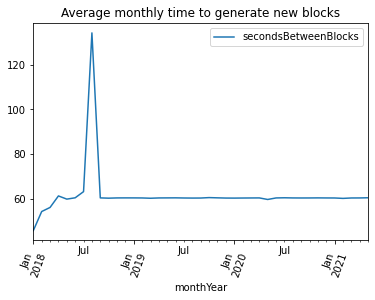

In [15]:
## The line / model
for i, col in enumerate(dfExploration.columns):
    dfExploration[col].plot()
    
plt.title('Average monthly time to generate new blocks')

plt.xticks(rotation=70)
plt.legend(dfExploration.columns)

# Results of the data exploration

We can see that the average time for creating new blocks has been stable from 09/2018, so that it is possible to predict the date of the next halvings

# Data Transformation - last step

In [16]:
df

,height,time
0,1778781,1622516234
1,1778780,1622516196
2,1778779,1622516185
3,1778778,1622516158
4,1778777,1622515956
...,...,...
1774755,5,1515015840
1774756,4,1515015833
1774757,3,1515015816
1774758,2,1515015759


In [17]:
df.sort_values(by=['height'], inplace=True)
df.reset_index(drop=True, inplace=True) 

df.head(10)

,height,time
0,1,1515015723
1,2,1515015759
2,3,1515015816
3,4,1515015833
4,5,1515015840
5,6,1515015847
6,7,1515015905
7,8,1515015936
8,9,1515015970
9,10,1515015971


### Cut data prior to 09/01/2018

In [18]:
cutoff_date = datetime(2018, 9, 1)
cutoff_date

datetime.datetime(2018, 9, 1, 0, 0)

In [19]:
cutoff_datetime = datetime.combine(cutoff_date, datetime.min.time())
cutoff_datetime

datetime.datetime(2018, 9, 1, 0, 0)

In [20]:
cutoff_timestamp = time.mktime(cutoff_datetime.timetuple())
cutoff_timestamp = int(cutoff_timestamp)
cutoff_timestamp

1535770800

In [21]:
df = df[df["time"] > cutoff_timestamp]
df

,height,time
337717,341701,1535770808
337718,341702,1535770841
337719,341703,1535770887
337720,341704,1535770907
337721,341705,1535770972
...,...,...
1774755,1778777,1622515956
1774756,1778778,1622516158
1774757,1778779,1622516185
1774758,1778780,1622516196


# Plotting the data

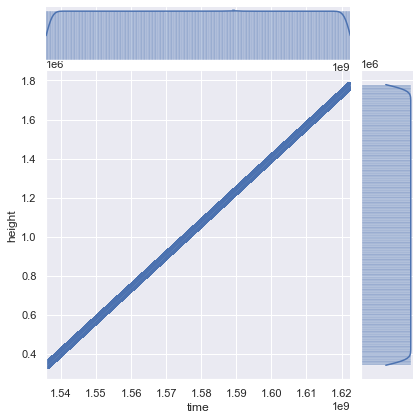

In [22]:
sns.set_theme(color_codes=True)
sns.jointplot(x='time', y='height', data=df, kind="reg")

# Correlation Analysis

In [23]:
correlations = df.corr()
correlations

,height,time
height,1.00000,1.00000
time,1.00000,1.00000


<AxesSubplot:>

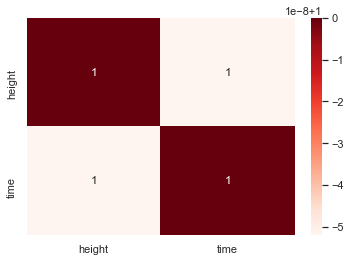

In [24]:
#heatmap


sns.heatmap(df.corr(),annot=True, cmap='Reds')

# Defining training and testing dataframes

In [25]:
# x = independent variable -> height
# y = dependent variable -> time

# here we have 1 variable for linear regression
X = df['height']
y = df['time']

X_training, X_test, y_training, y_test = train_test_split( X, y,
                                                          test_size = 0.2, random_state = 20210713)

print(f"Training dataframe: {X_training.shape[0]} lines")
print(f"Test dataframe....: {X_test.shape[0]} lines")

Training dataframe: 1149634 lines
Test dataframe....: 287409 lines


# Linear Regression

In [26]:
X_training = sm.add_constant(X_training)
X_test = sm.add_constant(X_test)

In [27]:
# Create a model and fit it
model_SM = sm.OLS(y_training, X_training).fit()
type(model_SM)

# SM = statsmodels

statsmodels.regression.linear_model.RegressionResultsWrapper

## Get results

In [28]:
print('Coefficient of Determination (𝑅²):', model_SM.rsquared)

Coefficient of Determination (𝑅²): 0.9999998959774744


In [29]:
print('Adjusted Coefficient of Determination (adjusted 𝑅²):', model_SM.rsquared_adj)

Adjusted Coefficient of Determination (adjusted 𝑅²): 0.9999998959773839


In [30]:
print('Regression Coefficients(intercept, 𝑏₀, 𝑏₁):\n', model_SM.params)

Regression Coefficients(intercept, 𝑏₀, 𝑏₁):
 const    1515155592.04584
height           60.35495
dtype: float64


In [31]:
print('P-values:\n', model_SM.pvalues)

P-values:
 const    0.00000
height   0.00000
dtype: float64


In [32]:
model_SM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.105e+13
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:00:33   Log-Likelihood:            -1.1974e+07
No. Observations:             1149634   AIC:                         2.395e+07
Df Residuals:                 1149632   BIC:                         2.395e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.515e+09     20.672   7.33e+07      0.000    1.52e+09    1.52e+09
height        60.3549   1.82e-05   3.32e+06      0.000      60.355      60.355
==============================================================================
Omnibus:                   101837.268   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66204.888
Skew:                           0.469   Prob(JB):                         0.00
Kurtosis:                       2.290   Cond. No.                     3.12e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 ## Evaluate

In [33]:
y_pred_SM = model_SM.predict(X_test)
print('predicted response:', y_pred_SM, sep='\n')

predicted response:
555866    1548945551.26831
821299    1564965866.96886
1572819   1610325386.93980
1427873   1601576454.34492
1133921   1583834272.32448
                ...       
606496    1552001443.01035
1312800   1594630927.60509
1542586   1608500494.72317
623655    1553037073.56814
1676371   1616575383.25549
Length: 287409, dtype: float64


Text(0, 0.5, 'Predictions')

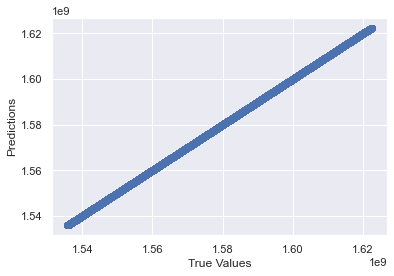

In [34]:
## The line / model
plt.scatter(y_test, y_pred_SM)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [35]:
print('Mean Absolute Error(MAE): ', metrics.mean_absolute_error(y_test, y_pred_SM))

Mean Absolute Error(MAE):  6525.262966041408


In [36]:
print('Mean Square Error(MSE): ', metrics.mean_squared_error(y_test, y_pred_SM))

Mean Square Error(MSE):  65073053.70010137


In [37]:
print('Root Mean Square Error(RMSE): ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_SM)))

Root Mean Square Error(RMSE):  8066.787074176519


## About the results

R2 and the graph of predictions vs correct values give us good results, while MAE, MSE and RMSE indicate that the model is bad.

Let's examine the data and determine what the forecast error is on a scale of minutes, so we'll know how useful a forecast obtained with this model can be.

In [38]:
dfResults = pd.DataFrame()
dfResults= pd.concat([y_test, y_pred_SM], axis=1)
dfResults.rename(columns={0:"prediction"}, inplace=True)
dfResults

,time,prediction
555866,1548943376,1548945551.26831
821299,1564970602,1564965866.96886
1572819,1610326237,1610325386.93980
1427873,1601571728,1601576454.34492
1133921,1583846688,1583834272.32448
...,...,...
606496,1551997975,1552001443.01035
1312800,1594620203,1594630927.60509
1542586,1608500160,1608500494.72317
623655,1553035136,1553037073.56814


In [39]:
# Handling the dates
dfResults.sort_index(inplace=True)

dfResults['dateTime']  = dfResults['time']
dfResults['dateTime']  = dfResults['dateTime'].apply(timestampToDateTime)

dfResults['dateTime_pred']  = dfResults['prediction']
dfResults['dateTime_pred']  = dfResults['dateTime_pred'].apply(timestampToDateTime)

dfResults

,time,prediction,dateTime,dateTime_pred
337718,1535770841,1535778998.58797,2018-09-01 00:00:41,2018-09-01 02:16:38.587965
337720,1535770907,1535779119.29786,2018-09-01 00:01:47,2018-09-01 02:18:39.297862
337725,1535771192,1535779421.07260,2018-09-01 00:06:32,2018-09-01 02:23:41.072603
337726,1535771219,1535779481.42755,2018-09-01 00:06:59,2018-09-01 02:24:41.427551
337727,1535771479,1535779541.78250,2018-09-01 00:11:19,2018-09-01 02:25:41.782500
...,...,...,...,...
1774728,1622514088,1622511956.32468,2021-05-31 23:21:28,2021-05-31 22:45:56.324683
1774730,1622514365,1622512077.03458,2021-05-31 23:26:05,2021-05-31 22:47:57.034580
1774732,1622514596,1622512197.74448,2021-05-31 23:29:56,2021-05-31 22:49:57.744476
1774736,1622514853,1622512439.16427,2021-05-31 23:34:13,2021-05-31 22:53:59.164269


In [40]:
dfResults['error'] = (dfResults['dateTime'] - dfResults['dateTime_pred']).astype('timedelta64[m]')
dfResults['error'] = dfResults['error'].fillna(0)
dfResults

,time,prediction,dateTime,dateTime_pred,error
337718,1535770841,1535778998.58797,2018-09-01 00:00:41,2018-09-01 02:16:38.587965,-136.00000
337720,1535770907,1535779119.29786,2018-09-01 00:01:47,2018-09-01 02:18:39.297862,-137.00000
337725,1535771192,1535779421.07260,2018-09-01 00:06:32,2018-09-01 02:23:41.072603,-138.00000
337726,1535771219,1535779481.42755,2018-09-01 00:06:59,2018-09-01 02:24:41.427551,-138.00000
337727,1535771479,1535779541.78250,2018-09-01 00:11:19,2018-09-01 02:25:41.782500,-135.00000
...,...,...,...,...,...
1774728,1622514088,1622511956.32468,2021-05-31 23:21:28,2021-05-31 22:45:56.324683,35.00000
1774730,1622514365,1622512077.03458,2021-05-31 23:26:05,2021-05-31 22:47:57.034580,38.00000
1774732,1622514596,1622512197.74448,2021-05-31 23:29:56,2021-05-31 22:49:57.744476,39.00000
1774736,1622514853,1622512439.16427,2021-05-31 23:34:13,2021-05-31 22:53:59.164269,40.00000


In [41]:
dfError = pd.DataFrame()
dfError['error_min'] = dfResults['error'].astype(int)

dfError.sort_index(inplace=True)

dfError.reset_index(inplace=True)
dfError = dfError.drop('index', 1)

dfError

,error_min
0,-136
1,-137
2,-138
3,-138
4,-135
...,...
287404,35
287405,38
287406,39
287407,40


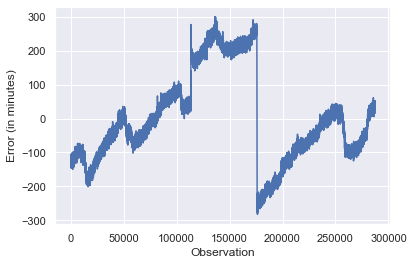

In [42]:
plt.plot(dfError)
plt.xlabel("Observation")
plt.ylabel("Error (in minutes)")
plt.show()

In [43]:
dfError['error_min_module'] = dfError['error_min'].abs()
dfError

,error_min,error_min_module
0,-136,136
1,-137,137
2,-138,138
3,-138,138
4,-135,135
...,...,...
287404,35,35
287405,38,38
287406,39,39
287407,40,40


In [44]:
def toHourMin(minutes):
    
    minutes = abs(minutes)
    
    h = 0
    m = 0
    
    if (minutes % 60 >= 0):
        h = int(minutes/60)
        m = int(minutes % 60)
    else:
        m = minutes

    return str(h)+'h '+str(m)+ 'm'

In [45]:
print('Highest error value: ', dfError['error_min'].max())
toHourMin(dfError['error_min'].max())

Highest error value:  301


'5h 1m'

In [46]:
print('Lowest error value: ', dfError['error_min'].min())
toHourMin(dfError['error_min'].min())

Lowest error value:  -283


'4h 43m'

In [47]:
print('Average error: ', dfError['error_min_module'].mean())
toHourMin(dfError['error_min_module'].mean())

Average error:  108.8352626396529


'1h 48m'

## Understanding the error

In [48]:
dfErrorAnalysis = dfError['error_min'].value_counts(bins = 7, sort=False)

dfErrorAnalysis = dfErrorAnalysis.reset_index()
dfErrorAnalysis.rename(columns={'index':'Class_Interval'}, inplace=True)

dfErrorAnalysis.rename(columns={'error_min':'Frequency'}, inplace=True)

dfErrorAnalysis['Relative_Frequency'] = dfErrorAnalysis['Frequency']/dfErrorAnalysis['Frequency'].sum()

dfErrorAnalysis

,Class_Interval,Frequency,Relative_Frequency
0,"(-283.585, -199.571]",14584,0.05074
1,"(-199.571, -116.143]",33783,0.11754
2,"(-116.143, -32.714]",93234,0.32439
3,"(-32.714, 50.714]",66962,0.23299
4,"(50.714, 134.143]",16423,0.05714
5,"(134.143, 217.571]",33211,0.11555
6,"(217.571, 301.0]",29212,0.10164


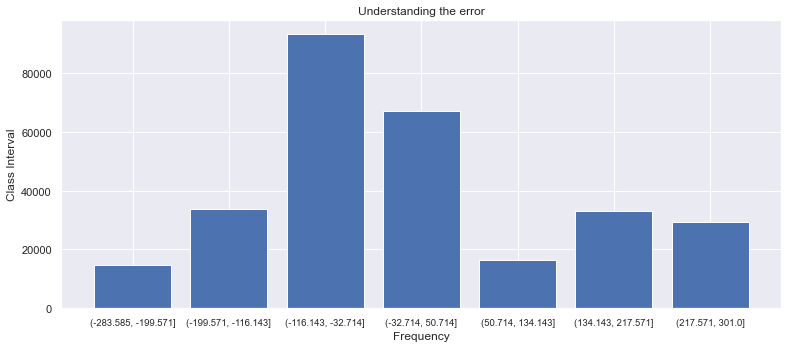

In [49]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0,0,1,1])
ax.bar(dfErrorAnalysis['Class_Interval'].astype(str), dfErrorAnalysis['Frequency'])
plt.xticks(size = 9.5)
plt.grid(True)
plt.title('Understanding the error')
plt.xlabel('Frequency')
plt.ylabel('Class Interval')
plt.show()

## Conclusion on the evaluation of results

Considering the maximum margin of error of about 5 hours, the application of this technique seems to be didactically adequate for the purpose of trying to predict the moment of occurrence of the next Ravencoin reduction.

## Real world application: Predicting the next halvings

In [50]:
blocks2HalvingRVN = 2100000
blocks2nextHalvingsRVN = [blocks2HalvingRVN, blocks2HalvingRVN*2, blocks2HalvingRVN*3, blocks2HalvingRVN*4]
new_x = np.array(blocks2nextHalvingsRVN).reshape((-1, 1))
new_x = sm.add_constant(new_x)
new_x

array([[1.0e+00, 2.1e+06],
       [1.0e+00, 4.2e+06],
       [1.0e+00, 6.3e+06],
       [1.0e+00, 8.4e+06]])

In [51]:
new_y = model_SM.predict(new_x)
print('predicted response:', new_y, sep='\n')

predicted response:
[1.64190098e+09 1.76864637e+09 1.89539177e+09 2.02213716e+09]


In [52]:
dfHalvingProjection = pd.DataFrame(new_y)
dfHalvingProjection.columns = ['predicted_timestamp']
dfHalvingProjection

,predicted_timestamp
0,1641900983.46429
1,1768646374.88275
2,1895391766.30120
3,2022137157.71966


In [53]:
# Making timestamp humanly friendly
# For each timestamp a new block is generated, and each block corresponds to 5,000 new coins.

dfHalvingProjection['predicted_date']  = dfHalvingProjection['predicted_timestamp']
dfHalvingProjection['predicted_date']  = dfHalvingProjection['predicted_timestamp'].apply(timestampToDate)

dfHalvingProjection['predicted_datetime']  = dfHalvingProjection['predicted_timestamp']
dfHalvingProjection['predicted_datetime']  = dfHalvingProjection['predicted_timestamp'].apply(timestampToDateTime)
dfHalvingProjection

,predicted_timestamp,predicted_date,predicted_datetime
0,1641900983.46429,2022-01-11,2022-01-11 08:36:23.464292
1,1768646374.88275,2026-01-17,2026-01-17 07:39:34.882746
2,1895391766.30120,2030-01-23,2030-01-23 06:42:46.301201
3,2022137157.71966,2034-01-29,2034-01-29 05:45:57.719656


In [54]:
dfPlot = pd.DataFrame()
dfPlot['Forecast'] = dfHalvingProjection['predicted_date']
dfPlot

,Forecast
0,2022-01-11
1,2026-01-17
2,2030-01-23
3,2034-01-29


In [55]:
# Adding date of first mined block
dfPlot.loc[4] = [datetime.strptime('10/03/2018', '%d/%m/%Y').date()]
dfPlot.sort_values(by=['Forecast'], inplace=True)

dfPlot.reset_index(inplace=True)
dfPlot = dfPlot.drop('index', 1)

dfPlot.reset_index(inplace=True)
dfPlot.rename(columns={'index':'Halving'}, inplace=True)

dfPlot

,Halving,Forecast
0,0,2018-03-10
1,1,2022-01-11
2,2,2026-01-17
3,3,2030-01-23
4,4,2034-01-29


In [56]:
#The first halving only happen in 2022
dfPlot.at[0, 'Halving'] = 1
dfPlot

,Halving,Forecast
0,1,2018-03-10
1,1,2022-01-11
2,2,2026-01-17
3,3,2030-01-23
4,4,2034-01-29


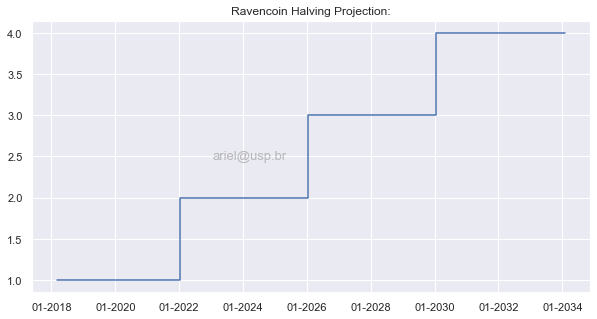

In [57]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(10, 5))

date_form = DateFormatter("%m-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.text(0.39, 0.5, 'ariel@usp.br', fontsize=13, ha='center', va='center',
           transform=ax.transAxes, color='grey', alpha=0.5)

plt.title('Ravencoin Halving Projection:')

plt.step(dfPlot['Forecast'], dfPlot['Halving'])

plt.show()

The validity of the projection shown in the graph depends on the allocated mining power and the difficulty setting. Maintaining current conditions, the first halving should take place on January 11, 2022.

An indication that our projection may be correct is that the official Ravencoin website informs that the first halving is expected to take place in January 2022. Source: https://ravencoin.org/halving/

It is too early to make an assertive prediction of the subsequent halvings, the prediction attempt was made just to facilitate the understanding of the results.